# Generación del Dataset de Productos para Recomendación por Cosine Similarity

## Objetivo
El objetivo de esta etapa es crear un **DataFrame de características** donde cada fila representa un producto y las columnas contienen variables numéricas o codificadas que describen sus características. Este conjunto de datos será la base para el cálculo de similitudes entre productos mediante la métrica de **Cosine Similarity**, permitiendo realizar recomendaciones en un entorno retail.

---

## Variables Seleccionadas
Para construir el DataFrame se han seleccionado las siguientes variables por producto:

### Variables Numéricas:
- **item_price**: Precio medio del producto.
- **product_quantity**: Cantidad media comprada del producto.
- **was_purchased**: Frecuencia de compra del producto.

### Variables Categóricas:
- **gender**: Género del producto.
- **mastercategory**: Categoría principal del producto.
- **subcategory**: Subcategoría del producto.
- **articletype**: Tipo de artículo.
- **basecolour**: Color principal del producto.
- **season**: Temporada a la que pertenece el producto.
- **year**: Año de lanzamiento del producto.
- **usage**: Uso principal del producto.

## Proceso de Construcción del Dataset
1. **Extracción de Datos:** Los datos se extraen desde la base de datos SQL.
2. **Preprocesamiento de Datos:**
   - Las variables categóricas se codifican mediante One-Hot Encoding.
   - Las variables numéricas se estandarizan con `StandardScaler`.
3. **Construcción del DataFrame de Características:** Se unen todas las variables en un solo DataFrame con el índice basado en el `product_id`.

---

## Resultado Esperado
Un **DataFrame de características** listo para calcular la similitud entre productos utilizando Cosine Similarity. Esto permitirá, en etapas posteriores, recomendar productos similares a los que un cliente ha comprado o visualizado, optimizando la experiencia de usuario en el entorno retail.


In [27]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine,text
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from IPython.display import display, Image, HTML
import random
import folium

In [2]:
# Cargar variables de entorno
load_dotenv(override=True)

# Configuración de conexión
DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_PORT = os.getenv("DB_PORT")

# Crear el motor de conexión a PostgreSQL
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

In [3]:
%%time
# Consulta SQL para obtener los datos requeridos
query = """
SELECT 
    product_id,
    item_price,
    product_quantity,
    was_purchased,
    gender,
    mastercategory,
    subcategory_grouped,
    articletype_grouped,
    basecolour_grouped,
    season,
    year,
    usage
FROM cleaned_base_table
"""

# Leer los datos desde PostgreSQL
df = pd.read_sql_query(query, engine)

# Agregación de variables numéricas por producto
agg_df = df.groupby('product_id').agg({
    'item_price': 'mean',
    'product_quantity': 'mean',
    'was_purchased': 'sum'
}).rename(columns={'was_purchased': 'purchase_count'})

# Variables categóricas: tomar la primera ocurrencia válida por producto
cat_df = df.drop_duplicates(subset='product_id')[
    ['product_id', 'gender', 'mastercategory', 'subcategory_grouped', 
     'articletype_grouped', 'basecolour_grouped', 'season', 'year', 'usage']
].set_index('product_id')

# Unir numéricas agregadas + categóricas
product_features = agg_df.join(cat_df)

# Crear la tabla en PostgreSQL
product_features.reset_index().to_sql(
    'product_features_similarity',  # nombre de la nueva tabla
    engine,
    index=False,
    if_exists='replace'  # reemplaza si ya existe
)

print("✅ Tabla 'product_features_similarity' creada correctamente.")


✅ Tabla 'product_features_similarity' creada correctamente.
CPU times: total: 31.4 s
Wall time: 1min 50s


### Paso 1.2: Análisis exploratorio de variables numéricas para Cosine Similarity

Antes de calcular la similitud entre productos, es fundamental analizar y depurar las variables numéricas que van a intervenir en el modelo. Un análisis preliminar permite detectar y corregir problemas comunes como valores nulos, outliers o escalas dispares entre variables.

#### Objetivo

Evaluar la calidad y distribución de las variables numéricas que describen cada producto, y que se utilizarán para construir el espacio vectorial sobre el cual se aplicará la métrica de similitud del coseno.

#### Variables analizadas

- `item_price`: Precio medio del producto.
- `product_quantity`: Cantidad media adquirida por compra.
- `purchase_count`: Número total de veces que el producto fue comprado.

#### Aspectos a revisar

1. **Valores nulos**: Detección de ausencias que puedan sesgar o impedir el cálculo.
2. **Estadísticos descriptivos**: Media, mediana, desviación estándar, valores mínimos y máximos.
3. **Outliers**: Detección de valores atípicos mediante el método del rango intercuartílico (IQR) o puntuaciones z.
4. **Distribución**: Análisis visual con histogramas o boxplots.
5. **Escalado** (opcional): En caso de diferencias significativas de escala entre variables, se considerará aplicar transformaciones como normalización o estandarización.

#### Resultado esperado

Una versión depurada de las variables numéricas lista para integrarse al dataset final codificado, garantizando que los cálculos de similitud no se vean distorsionados por anomalías en los datos.

In [4]:
%time
# Consulta SQL para extraer variables numéricas
query = """
SELECT 
    item_price,
    product_quantity,
    purchase_count
FROM product_features_similarity
"""

# Cargar datos en DataFrame
df_num = pd.read_sql_query(query, engine)

# Estadísticas descriptivas + nulos
summary = df_num.describe().T
summary['missing_values'] = df_num.isnull().sum()

summary

CPU times: total: 0 ns
Wall time: 0 ns


,count,mean,std,min,25%,50%,75%,max,missing_values
item_price,44446.0,258412.287702,24636.595541,172466.421053,240134.797991,257911.166667,277525.396164,374575.733333,0
product_quantity,44446.0,1.457776,0.274779,1.000000,1.269231,1.407407,1.586207,3.892857,0
purchase_count,44446.0,28.227017,5.303916,9.000000,25.000000,28.000000,32.000000,52.000000,0


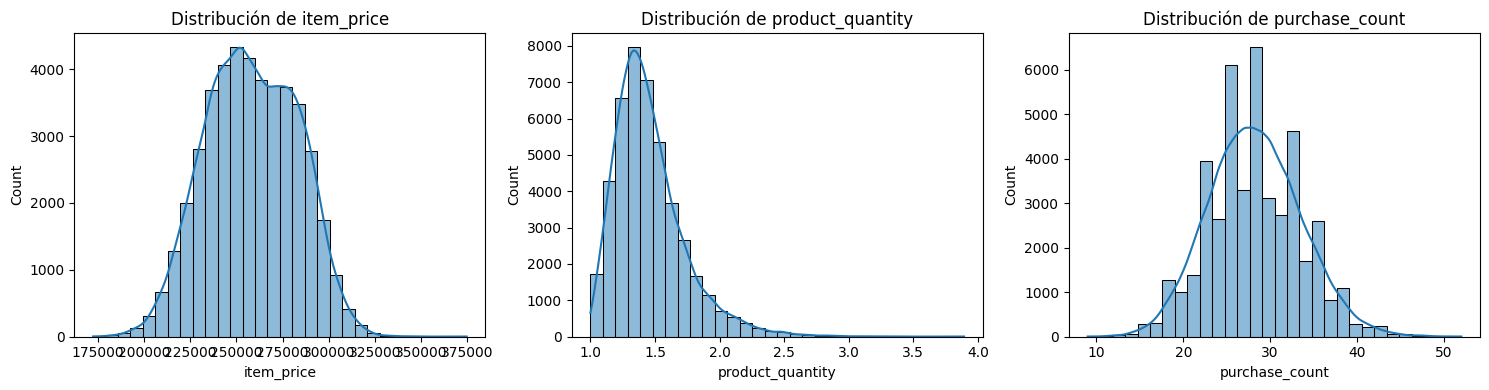

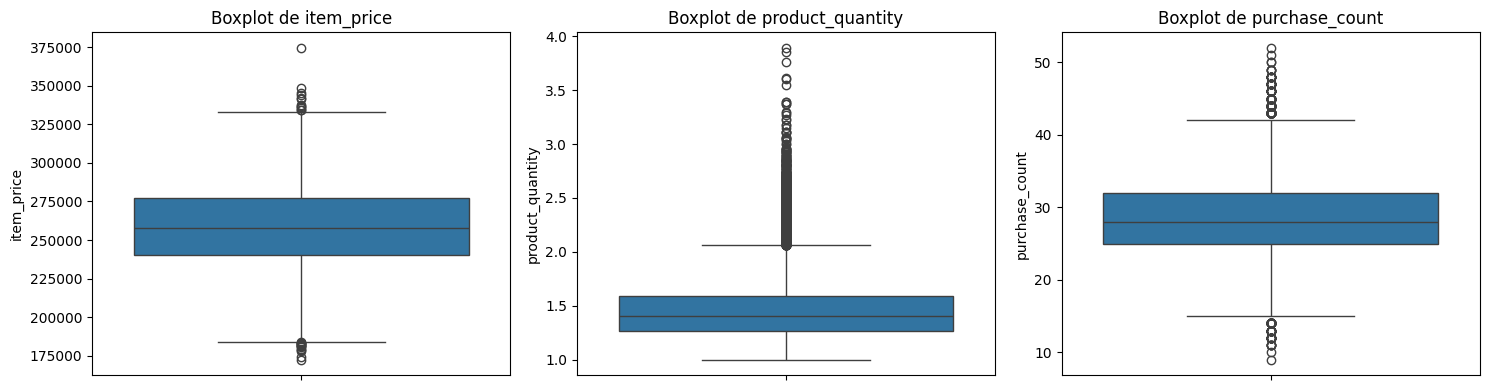

CPU times: total: 1.67 s
Wall time: 1.73 s


In [5]:
%%time
# Histogramas
plt.figure(figsize=(5 * len(df_num.columns), 4))
for i, col in enumerate(df_num.columns):
    plt.subplot(1, len(df_num.columns), i + 1)
    sns.histplot(df_num[col].dropna(), bins=30, kde=True)
    plt.title(f'Distribución de {col}')
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(5 * len(df_num.columns), 4))
for i, col in enumerate(df_num.columns):
    plt.subplot(1, len(df_num.columns), i + 1)
    sns.boxplot(y=df_num[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

### Paso 1.3: Análisis exploratorio de variables numéricas – Resultados

Tras analizar las variables numéricas `item_price`, `product_quantity` y `purchase_count`, se han identificado outliers en las tres. A continuación se detallan los hallazgos clave:

#### 1. `item_price`
- **Distribución**: aproximadamente normal, centrada en torno a los 258.000.
- **Rango observado**: [172.466, 374.576].
- **Outliers**: presencia de valores extremos por encima de los 330.000, detectados en el boxplot.
- **Posible causa**: productos de alto precio o registros erróneos.

#### 2. `product_quantity`
- **Distribución**: sesgada hacia la derecha, con valores concentrados entre 1.0 y 2.0.
- **Rango observado**: [1.0, 3.89].
- **Outliers**: gran número de valores superiores a 2.0; posibles compras múltiples o errores de carga.

#### 3. `purchase_count`
- **Distribución**: similar a una gaussiana centrada en torno a 28.
- **Rango observado**: [9, 52].
- **Outliers**: valores superiores a 45 son escasos pero visibles; podrían ser productos muy populares o errores acumulativos.

#### Conclusión

Todas las variables muestran **valores atípicos significativos** que podrían afectar negativamente a los cálculos de similitud. En el siguiente paso, se procederá a aplicar un **filtro basado en el rango intercuartílico (IQR)** para eliminar dichos outliers y preparar un dataset limpio y robusto para el modelo basado en Cosine Similarity.

In [6]:
%%time
# Cargar variables numéricas
query = """
SELECT 
    item_price,
    product_quantity,
    purchase_count
FROM product_features_similarity
"""
df = pd.read_sql_query(query, engine)

# Función para calcular % de outliers con IQR
def calcular_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[columna] < Q1 - 1.5 * IQR) | (df[columna] > Q3 + 1.5 * IQR)]
    return round(100 * len(outliers) / len(df), 2)

# Aplicar a cada variable
outlier_results = {
    col: calcular_outliers(df, col) for col in df.columns
}

# Mostrar como DataFrame
print(pd.DataFrame.from_dict(outlier_results, orient='index', columns=['% Outliers']))

                  % Outliers
item_price              0.06
product_quantity        3.69
purchase_count          0.81
CPU times: total: 781 ms
Wall time: 810 ms


### Paso 1.5: Conclusiones del análisis de outliers y decisión de tratamiento

Tras aplicar el método del rango intercuartílico (IQR) a las variables numéricas del dataset `product_features_similarity`, se obtuvo el siguiente porcentaje de outliers:

| Variable           | % Outliers |
|--------------------|------------|
| `item_price`        | 0.06%      |
| `product_quantity`  | 3.69%      |
| `purchase_count`    | 0.81%      |

#### Conclusiones

- Los niveles de outliers son en general bajos.
- La variable `product_quantity` presenta un número ligeramente más elevado, aunque manejable.
- Los outliers de `item_price` y `purchase_count` son muy poco frecuentes, pero pueden tener un impacto desproporcionado si no se gestionan correctamente.

#### Decisión de tratamiento

Se ha optado por **no eliminar** los registros con outliers, sino aplicar una **imputación basada en límites del IQR**. Esto permite:

- Conservar la mayor parte del dataset.
- Minimizar el impacto de valores atípicos extremos.
- Preparar un conjunto de datos más robusto para el cálculo de similitud entre productos.

#### Estrategia de imputación

Para cada variable numérica:
- Se calcularán los límites inferior y superior usando:

[Q1 - 1.5 × IQR, Q3 + 1.5 × IQR]

- Los valores por debajo del mínimo serán reemplazados por `Q1 - 1.5 × IQR`.
- Los valores por encima del máximo serán reemplazados por `Q3 + 1.5 × IQR`.

Este enfoque permite suavizar los efectos de los valores extremos sin perder información estructural del conjunto de datos.

In [7]:
%%time
# Leer toda la tabla
df = pd.read_sql_query("SELECT * FROM product_features_similarity", engine)

# Columnas numéricas a tratar
variables = ['item_price', 'product_quantity', 'purchase_count']

# Imputación de outliers por límites IQR
for col in variables:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower, upper=upper)

# Guardar nueva tabla en PostgreSQL
df.to_sql('product_features_similarity_cleaned', engine, index=False, if_exists='replace')

print("✅ Imputación de outliers realizada y tabla 'product_features_similarity_cleaned' creada.")

✅ Imputación de outliers realizada y tabla 'product_features_similarity_cleaned' creada.
CPU times: total: 1.27 s
Wall time: 1.93 s


### Paso 1.6: Evaluación de la necesidad de normalización de variables numéricas

Antes de aplicar la métrica de similitud del coseno sobre los vectores de características de producto, es importante estudiar si las variables numéricas deben ser normalizadas o escaladas. Aunque Cosine Similarity se basa en la orientación de los vectores y no directamente en la magnitud, las diferencias significativas de escala entre variables pueden alterar la influencia relativa de cada una en el cálculo.

#### Objetivo

Determinar si las variables numéricas (`item_price`, `product_quantity`, `purchase_count`) necesitan ser:

- **Estandarizadas** (z-score): para tener media 0 y desviación estándar 1.
- **Normalizadas** (min-max): para llevar todos los valores a un rango común, típicamente [0, 1].

#### Criterios a evaluar

1. **Comparación de escalas y rangos absolutos**: Identificar si alguna variable tiene una magnitud mucho mayor que las otras.
2. **Comparación de desviaciones estándar**: Evaluar si las variables tienen niveles de dispersión significativamente distintos.
3. **Visualización de distribuciones**: Ayuda a entender el comportamiento de las variables y cómo podría afectar a la similitud.

#### Resultado esperado

Una decisión fundamentada sobre si es necesario escalar las variables numéricas antes de aplicar `cosine_similarity`. Si la respuesta es afirmativa, se definirá la técnica más adecuada: estandarización o normalización.

In [8]:
%%time
# Cargar datos numéricos
query = """
SELECT 
    item_price,
    product_quantity,
    purchase_count
FROM product_features_similarity_cleaned
"""
df = pd.read_sql_query(query, engine)

# Estadísticas clave
stats = df.describe().T
stats['range'] = stats['max'] - stats['min']
stats['std/mean'] = stats['std'] / stats['mean']  # Coeficiente de variación

stats[['mean', 'std', 'range', 'std/mean']]

CPU times: total: 109 ms
Wall time: 127 ms


,mean,std,range,std/mean
item_price,258411.111797,24624.325347,149562.392692,0.095291
product_quantity,1.449197,0.247005,1.061671,0.170443
purchase_count,28.218771,5.260089,28.000000,0.186404


#### Conclusiones

- La variable `item_price` presenta una **magnitud absoluta muy superior** al resto de variables. Aunque su dispersión relativa es baja, puede **dominar el cálculo de similitud** si no se normaliza.
- Las variables `product_quantity` y `purchase_count` están en escalas similares, pero muy por debajo de `item_price`.
- Dado que Cosine Similarity **no es invariante a las magnitudes de las variables cuando hay combinaciones numéricas heterogéneas**, se recomienda realizar un ajuste previo.

### Paso 1.7: Evaluación de la normalidad de las variables numéricas (Shapiro-Wilk)

Antes de aplicar un proceso de escalado como `StandardScaler` (z-score), es recomendable comprobar si las variables numéricas siguen una distribución aproximadamente normal. Para ello, se ha aplicado la prueba de normalidad de **Shapiro-Wilk**, que es adecuada para conjuntos de datos pequeños y medianos (n ≤ 5000).

#### Variables evaluadas

- `item_price`
- `product_quantity`
- `purchase_count`

#### Procedimiento

Para cada variable:
1. Se ha extraído una muestra aleatoria de hasta 5000 registros (límite de la función `shapiro()` de SciPy).
2. Se ha aplicado la prueba de Shapiro-Wilk.
3. Se ha evaluado el valor-p (`p_value`), con el siguiente criterio:
   - Si **p > 0.05**: no se rechaza la hipótesis de normalidad.
   - Si **p ≤ 0.05**: se rechaza la hipótesis de normalidad (la variable **no** sigue distribución normal).

#### Resultado esperado

Una tabla con los siguientes valores por variable:

- **`statistic`**: estadístico de la prueba Shapiro-Wilk.
- **`p_value`**: valor-p de la prueba.
- **`normal_distribution`**: indicador booleano sobre si se acepta la hipótesis de normalidad.

#### Finalidad

Estos resultados permiten decidir si se puede aplicar una estandarización clásica (`StandardScaler`) o si es preferible usar otra técnica como `MinMaxScaler`, más robusta frente a distribuciones no normales.

In [9]:
%%time
# Consulta
query = """
SELECT 
    item_price,
    product_quantity,
    purchase_count
FROM product_features_similarity_cleaned
"""
df = pd.read_sql_query(query, engine)

# Test de Shapiro-Wilk (máximo 5000 observaciones por limitación del test)
resultados = {}
for col in df.columns:
    sample = df[col].dropna()
    if len(sample) > 5000:
        sample = sample.sample(n=5000, random_state=42)
    stat, p = shapiro(sample)
    resultados[col] = {
        'statistic': round(stat, 4),
        'p_value': round(p, 4),
        'normal_distribution': p > 0.05
    }

# Mostrar resultados
print(pd.DataFrame.from_dict(resultados, orient='index'))

                  statistic  p_value  normal_distribution
item_price           0.9932      0.0                False
product_quantity     0.9474      0.0                False
purchase_count       0.9944      0.0                False
CPU times: total: 62.5 ms
Wall time: 91.4 ms


#### Conclusiones

- Las tres variables numéricas **no siguen una distribución normal** según la prueba de Shapiro-Wilk.
- A pesar de ello, el uso de **`StandardScaler` sigue siendo recomendable**, dado que:
  - Las variables ya han sido limpiadas de outliers extremos.
  - La estandarización mejora la comparabilidad entre variables con escalas y rangos distintos.
  - Es compatible con métricas de distancia y similitud como `Cosine Similarity`.

#### Decisión

Se procederá a aplicar la transformación **z-score (StandardScaler)** a las variables `item_price`, `product_quantity` y `purchase_count`, antes de construir la matriz de similitud entre productos.

In [10]:
%%time
# Cargar la tabla limpia
df = pd.read_sql_query("SELECT * FROM product_features_similarity_cleaned", engine)

# Separar columnas
num_cols = ['item_price', 'product_quantity', 'purchase_count']
cat_cols = [col for col in df.columns if col not in num_cols + ['product_id']]

# Escalar numéricas
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols)
df_scaled['product_id'] = df['product_id'].values

# Unir con categóricas
df_cat = df[['product_id'] + cat_cols]
df_final = pd.merge(df_scaled, df_cat, on='product_id')

# Crear nueva tabla en PostgreSQL
df_final.to_sql('product_features_scaled', engine, index=False, if_exists='replace')

print("✅ Tabla 'product_features_scaled' creada con variables escaladas.")


✅ Tabla 'product_features_scaled' creada con variables escaladas.
CPU times: total: 1.45 s
Wall time: 2.06 s


### Paso 1.8: Codificación de variables categóricas (One-Hot Encoding)

Una vez imputados los outliers en las variables numéricas, el siguiente paso en la preparación del dataset para el modelo de recomendación consiste en codificar las variables categóricas. Dado que el algoritmo de Cosine Similarity requiere variables numéricas, es necesario transformar las categorías en variables binarias mediante codificación one-hot.

#### Variables categóricas codificadas

Se han codificado las siguientes columnas:

- `gender`
- `mastercategory`
- `subcategory_grouped`
- `articletype_grouped`
- `basecolour_grouped`
- `season`
- `usage`

Cada categoría única en estas columnas se convierte en una columna binaria (0 o 1), representando la presencia o ausencia de la categoría correspondiente en cada producto.

#### Resultado

- Se genera un nuevo DataFrame con todas las variables originales numéricas más las columnas binarias derivadas.
- El dataset codificado se guarda como una nueva tabla en PostgreSQL bajo el nombre: `product_features_encoded`.

Este dataset está completamente preparado para calcular la matriz de similitud entre productos utilizando la métrica del coseno (`Cosine Similarity`).

In [11]:
%%time
# Leer tabla limpia con outliers imputados
df = pd.read_sql_query("SELECT * FROM product_features_scaled", engine)

# Variables categóricas a codificar
categorical_columns = [
    'gender', 'mastercategory', 'subcategory_grouped',
    'articletype_grouped', 'basecolour_grouped', 'season', 'usage'
]

# Aplicar codificación one-hot
df_encoded = pd.get_dummies(df, columns=categorical_columns)

# Guardar nueva tabla en la base de datos
df_encoded.to_sql('product_features_encoded', engine, index=False, if_exists='replace')

print("✅ Tabla codificada 'product_features_encoded' creada correctamente.")

✅ Tabla codificada 'product_features_encoded' creada correctamente.
CPU times: total: 6.48 s
Wall time: 7.81 s


# 1.10 Generación y Almacenamiento de la Matriz de Similitud

## Objetivo
El objetivo de esta fase es calcular la **matriz de similitud** entre todos los productos utilizando la métrica de **Cosine Similarity** y almacenarla en una tabla dedicada dentro de la base de datos PostgreSQL. Esto permite realizar consultas rápidas y eficientes para recomendaciones futuras, sin necesidad de recalcular la matriz en cada petición.

---

## Proceso
1. **Carga de datos desde la base de datos**:
   - Se extraen las características codificadas y escaladas desde la tabla `product_features_encoded`.
   - Se incluye el nombre del producto (`productdisplayname`) y su URL (`image_url`) desde la tabla original `cleaned_base_table`.

2. **Cálculo de la Matriz de Similitud**:
   - Se utiliza el método `cosine_similarity` de `sklearn` para calcular la similitud entre vectores de productos.
   - El resultado es una matriz cuadrada donde cada celda representa el grado de similitud entre dos productos.

3. **Transformación de la Matriz para Almacenamiento**:
   - Se convierte la matriz en un formato de DataFrame:
     - `product_id_1`: ID del producto base.
     - `product_id_2`: ID del producto similar.
     - `similarity_score`: Grado de similitud (0 a 1).
   - Se eliminan los valores de autosemejanza (misma fila y columna) para optimización.

4. **Almacenamiento en PostgreSQL**:
   - Se guarda en una nueva tabla llamada `product_similarity_matrix`.
   - Esto permite realizar recomendaciones sin recalcular, mejorando la eficiencia del sistema.

---

## Resultado esperado
Una tabla optimizada y persistente en la base de datos llamada `product_similarity_matrix`, lista para realizar consultas rápidas y eficientes en futuras recomendaciones.


In [12]:
%%time
# Leer la tabla codificada y la columna de nombres e imágenes
query = """
SELECT pf.*, p.productdisplayname, p.image_url
FROM product_features_encoded pf
LEFT JOIN (
    SELECT DISTINCT product_id, productdisplayname, image_url
    FROM cleaned_base_table
) p ON pf.product_id = p.product_id
"""
df = pd.read_sql_query(query, engine)

# Separar IDs y características
product_ids = df['product_id']
df_features = df.drop(columns=['product_id', 'productdisplayname', 'year', 'image_url'])

# Calcular matriz de similitud
similarity_matrix = cosine_similarity(df_features)

# Transformar la matriz en un DataFrame plano
similarity_df = pd.DataFrame(similarity_matrix, index=product_ids, columns=product_ids)

# Convertir la matriz en un formato largo para almacenar en SQL
similarity_long = similarity_df.stack().reset_index()
similarity_long.columns = ['product_id_1', 'product_id_2', 'similarity_score']

# Eliminar autosemejanza (mismo producto)
similarity_long = similarity_long[similarity_long['product_id_1'] != similarity_long['product_id_2']]

# Guardar en PostgreSQL
similarity_long.to_sql('product_similarity_matrix', engine, index=False, if_exists='replace')

print("✅ Matriz de similitud almacenada correctamente en la tabla 'product_similarity_matrix'.")


MemoryError: Unable to allocate 7.36 GiB for an array with shape (1975446916,) and data type int32

### Paso 1.10: Recomendación optimizada con K-Nearest Neighbors y Cosine Similarity

Dado que el cálculo de la matriz completa de similitud coseno para ~44.000 productos generaba un error de memoria (`MemoryError`), se optó por una solución más eficiente utilizando el algoritmo `K-Nearest Neighbors` (KNN) con métrica de similitud coseno (`metric='cosine'`).

#### Enfoque adoptado

- Se ha utilizado el algoritmo `brute` de `NearestNeighbors` para calcular los **Top 5 productos más similares** por cada producto.
- En lugar de construir la matriz completa n×n n \times n , se recuperan solo los **5 vecinos más cercanos** por fila.
- Esto reduce drásticamente el uso de memoria y tiempo de ejecución, haciéndolo escalable para grandes volúmenes de productos.

#### Detalles técnicos

- Se utiliza la tabla `product_features_encoded`, que incluye variables numéricas escaladas y variables categóricas codificadas con one-hot.
- Para cada producto, se recuperan:
  - El identificador del producto base (`product_id`)
  - El nombre (`product_name`)
  - El identificador del producto similar (`similar_product_id`)
  - El nombre del producto similar (`similar_product_name`)
  - El score de similitud (`similarity_score` = 1 - distancia coseno)

#### Función
Se ha definido una función `recomendar_producto(producto_id, top_n=5)` que permite obtener recomendaciones personalizadas de productos similares a partir de su identificador. Esta función utiliza los resultados precomputados con el algoritmo `KNN` y métrica de similitud coseno.

#### Objetivo

Facilitar la interpretación del sistema de recomendación devolviendo no solo los identificadores de los productos similares, sino también sus nombres comerciales.

#### Características

- La función verifica si el `product_id` existe en el dataset.
- Recupera y muestra el **nombre del producto buscado**.
- Devuelve una tabla con los `top_n` productos más similares, incluyendo:
  - `similar_product_id`
  - `similar_product_name`
  - `similarity_score` (cuanto más alto, mayor similitud)


In [25]:
%%time
# Leer tabla codificada + nombres de productos e imágenes
query = """
SELECT pf.*, p.productdisplayname, p.image_url
FROM product_features_encoded pf
LEFT JOIN (
    SELECT DISTINCT product_id, productdisplayname, image_url
    FROM cleaned_base_table
) p ON pf.product_id = p.product_id
"""
df = pd.read_sql_query(query, engine)

# Preparar datos para KNN
product_ids = df['product_id']
product_names = df.set_index('product_id')['productdisplayname']
image_urls = df.set_index('product_id')['image_url']
df_features = df.drop(columns=['product_id', 'productdisplayname', 'year', 'image_url'])

# Modelo KNN
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=6)
knn.fit(df_features)
distancias, indices = knn.kneighbors(df_features)

# Generar recomendaciones
recomendaciones = []
for i, (inds, dists) in enumerate(zip(indices, distancias)):
    base_id = product_ids.iloc[i]
    for idx, dist in zip(inds[1:], dists[1:]):
        sim_id = product_ids.iloc[idx]
        recomendaciones.append({
            'product_id': int(base_id),
            'product_name': product_names.loc[base_id],
            'image_url_main': image_urls.loc[base_id] if pd.notnull(image_urls.loc[base_id]) else None,
            'similar_product_id': int(sim_id),
            'similar_product_name': product_names.loc[sim_id],
            'image_url_similar': image_urls.loc[sim_id] if pd.notnull(image_urls.loc[sim_id]) else None,
            'similarity_score': round(1 - dist, 4)
        })

df_recommendations = pd.DataFrame(recomendaciones)

# Imagen por defecto
NO_IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/1/14/No_Image_Available.jpg"

# Función de recomendación visual
def recomendar_producto(producto_id, top_n=5):
    if producto_id not in product_names.index:
        return f"No se encontró el producto con ID {producto_id}."

    nombre_producto = product_names.loc[producto_id]
    resultados = df_recommendations[df_recommendations['product_id'] == producto_id]

    if resultados.empty:
        return f"No se encontraron recomendaciones para el producto {producto_id} ({nombre_producto})."

    resultados = resultados.sort_values(by='similarity_score', ascending=False).head(top_n)

    print(f"\nRecomendaciones para: [{producto_id}] {nombre_producto}\n")

    # Imagen por defecto
    def safe_img(url, width=80):
        url = url if pd.notnull(url) else NO_IMAGE_URL
        return f'<img src="{url}" width="{width}"/>'

    # Crear DataFrame para mostrar en HTML
    tabla = resultados.copy()
    tabla['Imagen'] = tabla['image_url_similar'].apply(lambda url: safe_img(url, width=80))
    tabla_html = tabla[['similar_product_id', 'similar_product_name', 'similarity_score', 'Imagen']].to_html(escape=False, index=False)

    # Mostrar imagen base
    url_base = resultados['image_url_main'].iloc[0]
    url_base = url_base if pd.notnull(url_base) else NO_IMAGE_URL
    print(f"Producto base:")
    display(Image(url=url_base, width=150))

    # Mostrar tabla HTML con imágenes
    display(HTML(tabla_html))


CPU times: total: 1min 1s
Wall time: 1min 30s


In [28]:
##### # Ejemplo de uso
producto_ejemplo = 1909
recomendar_producto(producto_ejemplo)


Recomendaciones para: [1909] Nike Mens Classic Sportswear T-shirt

Producto base:


similar_product_id,similar_product_name,similarity_score,Imagen
2089,Adidas Mens Pocket Polo T-shirt,0.9845,
22614,Nike Men Navy Blue T-shirt,0.9820,
7658,Puma Men's Toe Crusher Club Purple T-shirt,0.9701,
2615,Nike Black Bleed Blue T-shirt,0.9643,
7937,Puma Men's Tech Graphic Green Black T-shirt,0.9610,


# 1.12 Recomendación Personalizada Basada en Historial del Cliente

## Objetivo
El objetivo de esta fase es realizar recomendaciones de productos optimizadas para un cliente específico. La lógica se basa en tres niveles:
1. Si el cliente ha **comprado** productos previamente, se recomiendan productos similares.
2. Si no ha comprado, se buscan productos que haya **visualizado**.
3. Si no ha visualizado ni comprado, se seleccionan productos **aleatorios**.

---

## Enfoque Adoptado:
- Se utiliza un modelo de `K-Nearest Neighbors (KNN)` para calcular la similitud de productos.
- La métrica utilizada es la similitud coseno (`cosine similarity`) que compara los vectores de características de cada producto.
- Los datos se consultan directamente desde la base de datos PostgreSQL para mantener la información actualizada.

---

## Proceso:
### **1. Consulta del Historial del Cliente:**
   - Primero se consulta si el cliente ha realizado **compras**.
   - Si no existen registros de compra, se buscan **visualizaciones** de productos.
   - Si tampoco existen visualizaciones, se seleccionan **productos aleatorios** del catálogo.

### **2. Construcción del Modelo KNN:**
   - Se inicializa un modelo de KNN para identificar productos similares en un espacio vectorial.
   - Para cada producto base, se calculan los vecinos más cercanos, excluyendo el propio producto.

### **3. Visualización de Recomendaciones:**
   - Se presentan las imágenes, nombres y el grado de similitud (`similarity_score`) de cada producto recomendado.
   - La visualización incluye una imagen del producto base y una tabla HTML con los productos similares.

---

## Estructura del DataFrame Final:
| Columnas             | Descripción                                        |
|-----------------------|----------------------------------------------------|
| `product_id`         | ID del producto base del cliente                   |
| `product_name`       | Nombre del producto base                           |
| `image_url_main`     | URL de la imagen del producto base                 |
| `similar_product_id` | ID del producto similar                            |
| `similar_product_name` | Nombre del producto similar                      |
| `image_url_similar`  | URL de la imagen del producto similar              |
| `similarity_score`   | Grado de similitud (0 a 1, siendo 1 idéntico)      |

---

## Ejecución de la Función:
Para obtener recomendaciones para un cliente específico, se utiliza:
```python
recomendar_cliente(customer_id=12345, top_n=5)


In [29]:
%%time
# Cargar datos de productos y visualizaciones
query = """
SELECT pf.*, p.productdisplayname, p.image_url
FROM product_features_encoded pf
LEFT JOIN (
    SELECT DISTINCT product_id, productdisplayname, image_url
    FROM cleaned_base_table
) p ON pf.product_id = p.product_id
"""
df = pd.read_sql_query(query, engine)

# Preparar datos para KNN
product_ids = df['product_id']
product_names = df.set_index('product_id')['productdisplayname']
image_urls = df.set_index('product_id')['image_url']
df_features = df.drop(columns=['product_id', 'productdisplayname', 'year', 'image_url'])

# Modelo KNN
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=6)
knn.fit(df_features)
distancias, indices = knn.kneighbors(df_features)

# Imagen por defecto
NO_IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/1/14/No_Image_Available.jpg"

# Función de recomendación basada en cliente
def recomendar_cliente(customer_id, top_n=5):
    # --- Paso 1: Consulta de historial ---
    # 1.1 Productos comprados
    query_compras = f"""
    SELECT product_id FROM cleaned_base_table WHERE customer_id = {customer_id} AND was_purchased = TRUE
    """
    compras = pd.read_sql_query(query_compras, engine)['product_id'].tolist()

    if len(compras) > 0:
        print(f"Recomendando productos basados en compras del cliente {customer_id}...")
        base_ids = compras

    else:
        # 1.2 Productos visualizados si no ha comprado
        query_visitas = f"""
        SELECT product_id FROM cleaned_base_table WHERE customer_id = {customer_id}
        """
        visitas = pd.read_sql_query(query_visitas, engine)['product_id'].tolist()
        
        if len(visitas) > 0:
            print(f"Recomendando productos basados en visualizaciones del cliente {customer_id}...")
            base_ids = visitas
        else:
            # 1.3 Productos aleatorios si no ha visualizado ni comprado
            print(f"No se encontraron compras ni visualizaciones. Recomendando productos aleatorios...")
            base_ids = random.sample(product_ids.tolist(), min(top_n, len(product_ids)))
    
    # --- Paso 2: Generar recomendaciones ---
    recomendaciones = []
    for base_id in base_ids:
        if base_id in product_ids.values:
            idx = product_ids.tolist().index(base_id)
            inds = indices[idx][1:]  # Evitar el propio producto
            dists = distancias[idx][1:]
            for sim_id, dist in zip(inds, dists):
                recomendaciones.append({
                    'product_id': int(base_id),
                    'product_name': product_names.loc[base_id],
                    'image_url_main': image_urls.loc[base_id] if pd.notnull(image_urls.loc[base_id]) else NO_IMAGE_URL,
                    'similar_product_id': int(product_ids.iloc[sim_id]),
                    'similar_product_name': product_names.loc[product_ids.iloc[sim_id]],
                    'image_url_similar': image_urls.loc[product_ids.iloc[sim_id]] if pd.notnull(image_urls.loc[product_ids.iloc[sim_id]]) else NO_IMAGE_URL,
                    'similarity_score': round(1 - dist, 4)
                })

    # --- Paso 3: Mostrar resultados ---
    df_recommendations = pd.DataFrame(recomendaciones).sort_values(by='similarity_score', ascending=False).head(top_n)

    def safe_img(url, width=80):
        return f'<img src="{url}" width="{width}"/>'

    tabla = df_recommendations.copy()
    tabla['Imagen'] = tabla['image_url_similar'].apply(lambda url: safe_img(url, width=80))
    tabla_html = tabla[['similar_product_id', 'similar_product_name', 'similarity_score', 'Imagen']].to_html(escape=False, index=False)

    # Mostrar imagen base
    url_base = df_recommendations['image_url_main'].iloc[0] if not df_recommendations.empty else NO_IMAGE_URL
    display(Image(url=url_base, width=150))

    # Mostrar tabla HTML con imágenes
    display(HTML(tabla_html))


CPU times: total: 54.6 s
Wall time: 1min 26s


In [ ]:
##### # Ejemplo de uso
cliente_ejemplo = 60555
recomendar_cliente(cliente_ejemplo)

# 1.13 Guardado de la Matriz de Recomendación en PostgreSQL

## Objetivo
El objetivo de esta fase es **persistir en la base de datos** la matriz de similitud generada mediante el modelo de `K-Nearest Neighbors (KNN)`. Esto permite acceder a las recomendaciones de productos de forma rápida y eficiente, sin necesidad de recalcular el modelo en cada consulta.

---

## Justificación
El cálculo de similitudes en un espacio vectorial para miles de productos consume una cantidad significativa de memoria RAM y tiempo de cómputo. Para evitar recalcular la matriz en cada petición, se propone:
1. **Persistir la matriz de similitud en PostgreSQL**, lo cual permite:
   - Consultas rápidas mediante SQL.
   - Reducción del consumo de memoria en cálculos repetitivos.
   - Acceso concurrente para múltiples usuarios.
   
2. **Evitar duplicidades y recalculados innecesarios**:
   - Una vez almacenada la matriz, las recomendaciones se consultan con un simple `SELECT`.

3. **Mejora en la integración con APIs y BI**:
   - Los datos almacenados son fácilmente accesibles para integraciones con APIs REST y herramientas de visualización como Power BI o Tableau.

---

## Proceso de Implementación:
### **Entrenamiento del Modelo KNN**
   - Se utiliza el modelo `NearestNeighbors` con métrica de similitud coseno (`cosine similarity`).
   - El modelo calcula los 5 vecinos más cercanos para cada producto en un espacio vectorial.

### **Construcción del DataFrame de Recomendaciones**
   - Para cada producto base:
     - Se identifican los 5 productos más similares.
     - Se extraen los nombres y las imágenes.
     - Se calcula el score de similitud como \(1 - \text{distancia coseno}\).

### **Creación de la Tabla en PostgreSQL**
   - La tabla se denomina `product_knn_recommendations`.
   - Se incluye:
     - `product_id`: Identificador del producto base.
     - `product_name`: Nombre del producto base.
     - `image_url_main`: Imagen del producto base.
     - `similar_product_id`: Identificador del producto similar.
     - `similar_product_name`: Nombre del producto similar.
     - `image_url_similar`: Imagen del producto similar.
     - `similarity_score`: Grado de similitud.

### **Guardado en Bloques con Transacciones Forzadas**
   - Se divide el DataFrame en bloques de 1000 filas para optimización.
   - En cada bloque se ejecuta un `COMMIT` explícito para garantizar la persistencia.
   - Si el proceso se detiene, los datos previos ya están confirmados en la base de datos.

---


In [3]:
%%time
# Leer tabla codificada + nombres de productos e imágenes
query = """
SELECT pf.*, p.productdisplayname, p.image_url
FROM product_features_encoded pf
LEFT JOIN (
    SELECT DISTINCT product_id, productdisplayname, image_url
    FROM cleaned_base_table
) p ON pf.product_id = p.product_id
"""
df = pd.read_sql_query(query, engine)

# Preparar datos para KNN
product_ids = df['product_id']
product_names = df.set_index('product_id')['productdisplayname']
image_urls = df.set_index('product_id')['image_url']
df_features = df.drop(columns=['product_id', 'productdisplayname', 'year', 'image_url'])

# Modelo KNN
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=6)
knn.fit(df_features)
distancias, indices = knn.kneighbors(df_features)

# Crear DataFrame de recomendaciones
recomendaciones = []
for i, (inds, dists) in enumerate(zip(indices, distancias)):
    base_id = product_ids.iloc[i]
    for idx, dist in zip(inds[1:], dists[1:]):
        sim_id = product_ids.iloc[idx]
        recomendaciones.append({
            'product_id': int(base_id),
            'product_name': product_names.loc[base_id],
            'image_url_main': image_urls.loc[base_id] if pd.notnull(image_urls.loc[base_id]) else None,
            'similar_product_id': int(sim_id),
            'similar_product_name': product_names.loc[sim_id],
            'image_url_similar': image_urls.loc[sim_id] if pd.notnull(image_urls.loc[sim_id]) else None,
            'similarity_score': round(1 - dist, 4)
        })

df_recommendations = pd.DataFrame(recomendaciones)

# --- Guardar en PostgreSQL con commit forzado ---
with engine.connect() as conn:
    conn.execute(text("DROP TABLE IF EXISTS product_knn_recommendations"))
    conn.execute(text("""
        CREATE TABLE product_knn_recommendations (
            product_id BIGINT,
            product_name TEXT,
            image_url_main TEXT,
            similar_product_id BIGINT,
            similar_product_name TEXT,
            image_url_similar TEXT,
            similarity_score FLOAT
        )
    """))

    # Insertar en bloques para optimización
    print("Guardando datos en bloques...")
    for i in range(0, len(df_recommendations), 1000):
        chunk = df_recommendations.iloc[i:i + 1000]
        chunk.to_sql('product_knn_recommendations', conn, index=False, if_exists='append')
        conn.execute(text("COMMIT"))
    print("✅ Recomendaciones guardadas correctamente en la tabla 'product_knn_recommendations'.")


Guardando datos en bloques...
✅ Recomendaciones guardadas correctamente en la tabla 'product_knn_recommendations'.
CPU times: total: 1min 11s
Wall time: 1min 47s


# 1.14 Recomendación Personalizada para Cliente con Visualización Optimizada

## Objetivo
El objetivo de esta implementación es ofrecer recomendaciones personalizadas para un cliente específico, mejorando la presentación visual y optimizando el rendimiento en las consultas SQL. Además, se garantiza un tiempo de respuesta rápido consultando los datos del cliente directamente en las tablas originales, que están indexadas para mejorar la velocidad de búsqueda.

---

## **Flujo del Proceso:**
1. **Consulta de Datos del Cliente (Tablas Originales Indexadas):**
   - Se obtiene la información del cliente desde la tabla `customers` de PostgreSQL.
   - Se utiliza la tabla original porque está correctamente **indexada** para optimizar la velocidad de respuesta.
   - Si no se encuentra el cliente, el proceso se detiene.

2. **Consulta del Historial de Interacciones:**
   - En primer lugar, se consultan las **compras** realizadas en las tablas originales:
     - `products_transactions`: Relación entre productos y transacciones.
     - `transactions`: Sesiones de compra.
     - `products`: Información del producto.
   - Si no hay compras, se buscan **visualizaciones** en las tablas originales:
     - `click_stream`: Eventos de navegación.
     - `product_event_metadata`: Metadatos de productos vistos.
     - `products`: Información del producto.
   - Si no hay compras ni visualizaciones, se selecciona un producto aleatorio del catálogo.

3. **Generación de Recomendaciones:** 
   - Se consulta la tabla optimizada `product_knn_recommendations` en PostgreSQL.
   - Se buscan los productos más similares al producto base seleccionado.

4. **Visualización Optimizada:**
   - Si el producto fue comprado o visualizado, se muestra el mensaje:
     > "Porque has comprado: (producto base) te recomendamos..."
   - Si es aleatorio, se muestra el mensaje:
     > "Te podría interesar..."
   - En ambos casos, se presenta un listado visual con imágenes y nombres de los productos.

---

## **Optimización Aplicada:**
1. **Consultas SQL mejoradas:** 
   - Se limitan las consultas con un `LIMIT 1` para optimizar tiempos de respuesta.
   - Se evitan subconsultas innecesarias y se optimizan los joins.
   - Las tablas `customers`, `products`, `transactions`, `click_stream`, y `product_event_metadata` se consultan directamente por estar **indexadas**.

2. **Visualización Condicional:** 
   - Se controla si el producto seleccionado es aleatorio, para ajustar el mensaje.
   - Esto evita mostrar "Porque has comprado..." si en realidad fue un producto aleatorio.

3. **Uso de HTML enriquecido:** 
   - Las recomendaciones se muestran en un formato visualmente amigable con imágenes y enlaces.
   - Se usa un fallback de "No Image Available" si no se encuentra la imagen.

---

## **Estructura del Código:**
| Sección                    | Descripción                                                                 |
|----------------------------|-----------------------------------------------------------------------------|
| Datos del Cliente         | Muestra la información del cliente recuperada desde PostgreSQL.             |
| Consulta de Compras       | Si el cliente ha comprado, se selecciona un producto aleatorio de su historial. |
| Consulta de Visualizaciones | Si no hay compras, se buscan visualizaciones del cliente.                              |
| Productos Aleatorios      | Si no hay compras ni visualizaciones, se selecciona un producto aleatorio.   |
| Generación de Recomendaciones | Se buscan productos similares al producto base.                         |
| Visualización Optimizada  | Se muestra en HTML el producto base y los recomendados de manera amigable.   |

---

In [4]:
# Imagen por defecto si no se encuentra URL
NO_IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/1/14/No_Image_Available.jpg"

# Función principal optimizada
def recomendar_para_cliente(customer_id, top_n=5):
    # Mostrar datos del cliente
    query_cliente = f"""
    SELECT customer_id, first_name, last_name, email, home_location_lat, home_location_long
    FROM customers 
    WHERE customer_id = {customer_id}
    """
    cliente = pd.read_sql_query(query_cliente, engine)
    
    if cliente.empty:
        print(f"No se encontró el cliente con ID {customer_id}.")
        return
    
    # Variables del cliente
    first_name = cliente['first_name'].iloc[0]
    last_name = cliente['last_name'].iloc[0]
    email = cliente['email'].iloc[0]
    lat = cliente['home_location_lat'].iloc[0]
    lon = cliente['home_location_long'].iloc[0]
    
    # Mapa con la localización (Mapa reducido)
    if pd.notnull(lat) and pd.notnull(lon):
        mapa = folium.Map(location=[lat, lon], zoom_start=7, width=400, height=300)
        folium.Marker([lat, lon], popup=f"{first_name} {last_name}").add_to(mapa)
        mapa.save("mapa_cliente.html")
        
        # HTML para incrustar el mapa en un iframe
        mapa_html = """
        <iframe src="mapa_cliente.html" width="400" height="303" style="border: 2px solid #ccc; border-radius: 8px;"></iframe>
        """
    else:
        mapa_html = "<p>Localización no disponible</p>"

    # HTML para los datos
    datos_html = f"""
    <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px;'>
        <h3 style='margin-bottom: 5px;'>Información del Cliente:</h3>
        <p><b>Nombre:</b> {first_name} {last_name}</p>
        <p><b>Email:</b> {email}</p>
    </div>
    """

    # Mostrar los datos y el mapa juntos en una tabla
    display(HTML(f"""
    <table style='width: 100%; border-collapse: collapse;'>
        <tr>
            <td style='vertical-align: top; width: 50%; padding-right: 10px;'>
                {datos_html}
            </td>
            <td style='vertical-align: top; width: 50%;'>
                {mapa_html}
            </td>
        </tr>
    </table>
    """))

    # Flag para saber si es un producto comprado/visualizado o aleatorio
    es_aleatorio = False

    # Consulta de compras del cliente
    query_compras = f"""
    SELECT pt.product_id, p.productdisplayname, p.image_url 
    FROM customers c, products p, transactions t, products_transactions pt
    WHERE c.customer_id = {customer_id} AND pt.product_id = p.id AND t.session_id=pt.session_id AND c.customer_id=t.customer_id
    """
    compras = pd.read_sql_query(query_compras, engine)

    if not compras.empty:
        print("Historial de compras encontrado. Seleccionando un producto aleatoriamente...")
        producto_seleccionado = compras.sample(1)
    
    else:
        # Consulta de visualizaciones del cliente
        query_visitas = f"""
        SELECT pem.product_id, p.productdisplayname, p.image_url 
        FROM products p, customers c, click_stream cs, product_event_metadata pem, transactions t
        WHERE c.customer_id = {customer_id} AND cs.event_id=pem.event_id AND pem.product_id = p.id AND t.session_id=cs.session_id AND c.customer_id=t.customer_id AND pem.was_purchased = FALSE
        """
        visitas = pd.read_sql_query(query_visitas, engine)

        if not visitas.empty:
            print("No se encontraron compras. Seleccionando un producto visualizado aleatoriamente...")
            producto_seleccionado = visitas.sample(1)
        else:
            # Si no hay interacciones, mostrar productos aleatorios
            print("No se encontraron compras ni visualizaciones. Mostrando productos aleatorios...")
            query_aleatorio = """
            SELECT id as product_id, productdisplayname, image_url 
            FROM products 
            ORDER BY RANDOM() LIMIT 5
            """
            productos_aleatorios = pd.read_sql_query(query_aleatorio, engine)
            es_aleatorio = True  # Marcamos que es aleatorio

    if es_aleatorio:
        # Visualización HTML para productos aleatorios
        productos_aleatorios['Imagen'] = productos_aleatorios['image_url'].apply(
            lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
        )
        tabla_html = productos_aleatorios[['product_id', 'productdisplayname', 'Imagen']].to_html(escape=False, index=False)
        
        display(HTML(f"""
        <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px; margin-top: 10px;'>
            <h3>Te podría interesar...</h3>
            {tabla_html}
        </div>
        """))
        return

    # Datos del producto seleccionado
    producto_base_id = producto_seleccionado['product_id'].iloc[0]
    producto_base_nombre = producto_seleccionado['productdisplayname'].iloc[0]
    producto_base_img = producto_seleccionado['image_url'].iloc[0] if pd.notnull(producto_seleccionado['image_url'].iloc[0]) else NO_IMAGE_URL
    
    # Generar recomendaciones para el producto base
    query_recomendaciones = f"""
    SELECT 
        similar_product_id AS product_id, 
        similar_product_name AS product_name, 
        image_url_similar AS image_url,
        similarity_score 
    FROM product_knn_recommendations
    WHERE product_id = {producto_base_id}
    ORDER BY similarity_score DESC
    LIMIT {top_n}
    """
    
    recomendaciones = pd.read_sql_query(query_recomendaciones, engine)

    if not recomendaciones.empty:
        recomendaciones['Imagen'] = recomendaciones['image_url'].apply(
            lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
        )
        tabla_html = recomendaciones[['product_id', 'product_name', 'similarity_score', 'Imagen']].to_html(escape=False, index=False)

        display(HTML(f"""
        <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px; margin-top: 10px;'>
            <h3>Porque has comprado o visualizado:</h3>
            <img src="{producto_base_img}" width="100">
            <p><b>{producto_base_nombre}</b></p>
            <h3>Te recomendamos:</h3>
            {tabla_html}
        </div>
        """))


In [5]:
%%time
recomendar_para_cliente(1601)

Información del Cliente: Nombre: Keisha Rahmawati Email: 934743d4_9b68_465b_b0f2_aef8f91d613f@zakyfoundation.org,


Historial de compras encontrado. Seleccionando un producto aleatoriamente...


product_id,product_name,similarity_score,Imagen
14375,Catwalk Women Casual Matalic Flats,0.9992,
54105,Rocia Women White Flats,0.9980,
17662,Catwalk Women Buckel Black Heels,0.9967,
47547,Portia Women Silver Flats,0.9966,
17687,Catwalk Women Classic White Heels,0.9963,


CPU times: total: 46.9 ms
Wall time: 894 ms


## Sistema de Recomendación Basado en Annoy

Este sistema de recomendación utiliza la librería Annoy (Approximate Nearest Neighbors Oh Yeah) para encontrar productos similares a partir de un conjunto de características previamente preprocesadas y escaladas. El objetivo es obtener recomendaciones rápidas y eficientes sobre productos que comparten similitudes en atributos relevantes como precio, cantidad comprada, categoría, género, color, temporada y uso, entre otros.

### 1. Carga y preparación de los datos

Los datos utilizados provienen de una tabla preprocesada denominada `product_features_encoded`, que contiene vectores de características numéricas y codificadas (one-hot) por producto. Esta tabla fue generada en el **notebook de KNN**, donde se realizó el tratamiento y escalado de variables para su uso posterior en modelos de recomendación. Por tanto, partimos de una base de datos ya limpia, homogénea y lista para indexar.

A través de una consulta SQL, se unen estos datos con información descriptiva adicional del producto (nombre e imagen) procedente de la tabla `cleaned_base_table`, lo cual permite enriquecer las recomendaciones visualmente.

### 2. Construcción del índice con Annoy

Una vez cargados los datos, se construye un índice Annoy utilizando las columnas de características como vectores. Cada producto es representado como un vector de dimensión fija, y se añade al índice con un identificador numérico interno. La métrica utilizada es `angular`, que es equivalente a la similitud del coseno, comúnmente empleada en sistemas de recomendación.

El índice se construye mediante la creación de varios árboles para optimizar la búsqueda aproximada. Se utiliza una estructura balanceada que permite búsquedas eficientes en tiempo constante.

### 3. Generación de recomendaciones

A partir del identificador de un producto (`product_id`), el sistema recupera su índice interno y consulta el índice Annoy para obtener los vecinos más cercanos (productos similares). Se excluye el propio producto de los resultados, y se devuelve una tabla con los productos recomendados junto con su identificador, nombre y URL de imagen.

El sistema también calcula y presenta la distancia relativa entre los productos recomendados y el producto base, lo que facilita la interpretación de la similitud.

### 4. Ventajas del uso de Annoy

- Permite recomendaciones en tiempo real con bajo coste computacional.
- Escalable a millones de productos.
- Se puede guardar el índice en disco para su reutilización sin necesidad de reconstruirlo.
- Ideal para despliegues en producción o integraciones con aplicaciones de usuario (por ejemplo, chatbots o interfaces web).

### 5. Requisitos previos

Para ejecutar este sistema es necesario tener:
- Los datos ya preprocesados y escalados (generados en el notebook de KNN).
- La librería `annoy` instalada.
- Una conexión a la base de datos donde reside la tabla `product_features_encoded`.

Este enfoque mejora significativamente la eficiencia frente a métodos exactos como KNN tradicional, manteniendo una buena precisión en los resultados de recomendación.


In [6]:
from annoy import AnnoyIndex
import pickle

In [7]:
%%time
# Consulta SQL para unir características con información descriptiva
query = """
SELECT pf.*, p.productdisplayname, p.image_url
FROM product_features_encoded pf
LEFT JOIN (
    SELECT DISTINCT product_id, productdisplayname, image_url
    FROM cleaned_base_table
) p ON pf.product_id = p.product_id
"""

# Ejecutar la consulta y cargar el DataFrame
df = pd.read_sql(query, engine)

# Verificar carga de datos
print(df.shape)
df.head()

(44446, 62)
CPU times: total: 1.16 s
Wall time: 1min 8s


,item_price,product_quantity,purchase_count,product_id,year,gender_Boys,gender_Girls,gender_Men,gender_Unisex,gender_Women,...,usage_Casual,usage_Ethnic,usage_Formal,usage_Home,usage_Party,usage_Smart Casual,usage_Sports,usage_Travel,productdisplayname,image_url
0,-0.402684,-0.228093,-0.041591,1163.0,2011.0,False,False,True,False,False,...,False,False,False,False,False,False,True,False,Nike Sahara Team India Fanwear Round Neck Jersey,https://i.pinimg.com/736x/23/0c/f4/230cf479979...
1,-0.541449,-0.762451,-0.992156,1164.0,2015.0,False,False,True,False,False,...,False,False,False,False,False,False,True,False,Nike Men Blue T20 Indian Cricket Jersey,"https://assets.myntassets.com/h_200,w_200,c_fi..."
2,-0.361547,-1.683642,0.338635,1165.0,2013.0,False,False,True,False,False,...,False,False,False,False,False,False,True,False,Nike Mean Team India Cricket Jersey,"https://assets.myntassets.com/h_200,w_200,c_fi..."
3,0.962219,-0.239661,0.528748,1525.0,2010.0,False,False,False,True,False,...,True,False,False,False,False,False,False,False,Puma Deck Navy Blue Backpack,https://images.puma.net/images/076905/07/fnd/A...
4,1.353806,-0.066819,-0.611930,1526.0,2010.0,False,False,False,True,False,...,False,False,False,False,False,False,True,False,Puma Big Cat Backpack Black,https://s3-us-west-1.amazonaws.com/calzzapato/...


### 2. Preparación de Vectores y Construcción del Índice con Annoy

Con los datos cargados en un DataFrame, el siguiente paso es preparar los vectores de características que se utilizarán para construir el índice de búsqueda aproximada. Para ello, se excluyen las columnas no relevantes para el cálculo de similitud (como `product_id`, `productdisplayname` e `image_url`) y se seleccionan únicamente las variables numéricas y categóricas codificadas.

A continuación, se utiliza la biblioteca Annoy (Approximate Nearest Neighbors) para construir un índice basado en estos vectores. Cada producto se representa como un vector de dimensión fija, y se añade al índice usando un identificador numérico interno. Se emplea la métrica `angular`, equivalente a la similitud del coseno, ideal para recomendaciones de productos basadas en distancia angular en espacios vectoriales.

El índice se construye utilizando múltiples árboles (por ejemplo, 10), lo que permite un balance entre precisión y velocidad de búsqueda. Este índice servirá posteriormente para recuperar productos similares de forma rápida y eficiente.


In [8]:
%%time
# Seleccionar columnas de características (excluyendo ID, nombre e imagen)
feature_cols = [col for col in df.columns if col not in ['product_id', 'productdisplayname', 'image_url']]

# Definir la dimensión del vector
f = len(feature_cols)

# Crear índice Annoy usando métrica angular (equivalente a coseno)
annoy_index = AnnoyIndex(f, 'angular')

# Crear mapeos entre índice interno e ID de producto
product_id_map = {}
reverse_id_map = {}

# Añadir cada producto al índice
for i, row in df.iterrows():
    vector = row[feature_cols].values.astype('float32')
    annoy_index.add_item(i, vector)
    product_id_map[i] = row['product_id']
    reverse_id_map[row['product_id']] = i

# Construir el índice con 10 árboles
annoy_index.build(10)

CPU times: total: 14.2 s
Wall time: 12.7 s


True

### 3. Generación de Recomendaciones

Una vez construido el índice Annoy, se puede generar un sistema de recomendaciones de productos similares. Para ello, se define una función que, dado un `product_id` como entrada, recupera el índice interno correspondiente y consulta el índice Annoy para obtener los productos más cercanos en el espacio vectorial.

Se utiliza el método `get_nns_by_item` de Annoy, que devuelve los índices de los vecinos más próximos según la métrica definida (en este caso, distancia angular). Posteriormente, se transforman estos índices en identificadores reales de producto y se recupera la información descriptiva (nombre del producto e imagen) para mostrar al usuario final.

Este enfoque permite ofrecer recomendaciones personalizadas de forma rápida y escalable, con un rendimiento adecuado incluso en conjuntos de datos grandes.

Para facilitar la interpretación de las recomendaciones, se crea una función que muestra en una tabla HTML el producto consultado y los productos más similares. La visualización se realiza en un entorno Jupyter Notebook, lo que permite incluir imágenes directamente en las celdas de la tabla.

Cada fila de la tabla de resultados incluye:
- El identificador del producto (`product_id`)
- El nombre del producto (`productdisplayname`)
- Una imagen representativa (`image_url`)
- La distancia angular entre el producto consultado y el recomendado

Además, el producto original se muestra por separado al inicio, y se garantiza que **no se incluya en la lista de recomendaciones**, incluso si aparece entre los vecinos más cercanos por efecto del redondeo o duplicación en el índice.

Este formato de presentación es especialmente útil para validar visualmente la calidad de las recomendaciones y para integrar el sistema en interfaces orientadas al usuario final.

In [9]:
%%time
from IPython.display import display, HTML

def mostrar_recomendaciones_con_distancia(product_id, n=5):
    """
    Muestra el producto buscado y sus recomendaciones similares con imagen y distancia.
    Excluye explícitamente el producto original de los resultados.
    """
    idx = reverse_id_map.get(product_id)
    if idx is None:
        print(f"Producto {product_id} no encontrado en el índice.")
        return

    # Producto original
    producto_original = df.iloc[[idx]][['product_id', 'productdisplayname', 'image_url']]

    # Obtener vecinos y distancias
    vecinos_idx, distancias = annoy_index.get_nns_by_item(idx, n + 10, include_distances=True)  # recuperar más para filtrar luego

    recomendaciones = []
    for i, dist in zip(vecinos_idx, distancias):
        pid = df.iloc[i]['product_id']
        if pid != product_id:
            recomendaciones.append({
                'product_id': pid,
                'productdisplayname': df.iloc[i]['productdisplayname'],
                'image_url': df.iloc[i]['image_url'],
                'distance': dist
            })
        if len(recomendaciones) >= n:
            break

    recomendados_df = pd.DataFrame(recomendaciones)

    # Mostrar producto original
    print("Producto consultado:")
    display(HTML(producto_original.to_html(escape=False, formatters={
        'image_url': lambda x: f'<img src="{x}" width="100"/>'
    })))

    # Mostrar recomendaciones
    print("Productos recomendados:")
    display(HTML(recomendados_df.to_html(escape=False, formatters={
        'image_url': lambda x: f'<img src="{x}" width="100"/>',
        'distance': lambda x: f"{x:.4f}"
    })))

# Ejemplo
mostrar_recomendaciones_con_distancia(15240)  # reemplaza por un product_id real


Producto consultado:


,product_id,productdisplayname,image_url
11520,15240.0,ADIDAS Originals Men Valley-Fdt Black Casual Shoes,


Productos recomendados:


,product_id,productdisplayname,image_url,distance
0,10152.0,Rockport Men TR Bal Black Casual Shoes,,0.0002
1,41451.0,Lee Cooper Men White Sports Shoes,,0.0002
2,21210.0,Quiksilver Men White Cardone Casual Shoes,,0.0003
3,15518.0,Rockport Men Slatkin Grey Casual Shoes,,0.0003
4,26523.0,Provogue Men Black Casual Shoes,,0.0004


CPU times: total: 0 ns
Wall time: 45.6 ms


# 4.Recomendación de Productos Similares con Annoy y Visualización Optimizada

## Objetivo
El objetivo de esta implementación es ofrecer recomendaciones de productos similares basadas en características vectoriales mediante la librería Annoy (Approximate Nearest Neighbors). Se parte de un producto base y se generan recomendaciones rápidas y relevantes, presentadas en una tabla visual optimizada con imágenes y distancias relativas. Además, se garantiza que el producto original nunca aparezca entre los recomendados.

---

## **Flujo del Proceso:**
1. **Carga y Preparación de Datos:**
   - Se carga desde PostgreSQL una tabla preprocesada (`product_features_encoded`) que contiene vectores numéricos escalados para cada producto.
   - Se realiza una unión con la tabla `cleaned_base_table` para obtener el nombre del producto y su imagen.
   - El DataFrame final incluye tanto los vectores de recomendación como la información visual para la presentación.

2. **Construcción del Índice Annoy:**
   - Se utiliza la métrica `angular`, equivalente a similitud del coseno, para representar la distancia entre productos.
   - Cada producto se indexa con un identificador interno, permitiendo búsquedas aproximadas ultrarrápidas.
   - Se excluye de manera explícita el producto base de la lista de recomendaciones.

3. **Generación de Recomendaciones:**
   - A partir de un `product_id` se obtiene su índice interno y vector correspondiente.
   - Se recuperan los vecinos más cercanos mediante el índice Annoy.
   - Se calcula la distancia angular para cada producto recomendado.

4. **Visualización Optimizada:**
   - Se muestra primero el producto original con su imagen y nombre.
   - A continuación, se presentan los productos recomendados con su imagen, nombre y distancia al producto base.
   - La visualización se realiza en un entorno Jupyter Notebook utilizando HTML enriquecido.

---

## **Optimización Aplicada:**
1. **Indexación eficiente con Annoy:**
   - Se construye un índice con múltiples árboles para balancear velocidad y precisión.
   - Se permite guardar y reutilizar el índice sin reconstrucción.

2. **Control de duplicados:** 
   - Se garantiza que el producto base no se muestre entre los resultados, incluso si aparece por error en los vecinos más cercanos.

3. **Visualización enriquecida:**
   - Las recomendaciones se presentan en tablas HTML con imágenes.
   - Se muestra también la distancia relativa, para facilitar la interpretación de la similitud.
   - Si alguna imagen no está disponible, se puede incluir una imagen por defecto como fallback.

---

## **Estructura del Código:**
| Sección                        | Descripción                                                                 |
|-------------------------------|-----------------------------------------------------------------------------|
| Carga de Datos                | Se carga el DataFrame desde PostgreSQL uniendo características e imágenes. |
| Preparación de Vectores       | Se seleccionan las columnas relevantes y se construyen los vectores.       |
| Construcción del Índice Annoy | Se indexan los vectores con `angular` y se construye el índice.            |
| Generación de Recomendaciones | Se recuperan los vecinos más cercanos, excluyendo el producto original.   |
| Visualización Optimizada      | Se muestra el producto base y los recomendados con HTML e imágenes.        |


In [10]:
%%time

# Imagen por defecto
NO_IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/1/14/No_Image_Available.jpg"

def recomendar_para_cliente_annoy(customer_id, top_n=5):
    import folium
    from IPython.display import display, HTML

    # Consulta de datos del cliente
    query_cliente = f"""
    SELECT customer_id, first_name, last_name, email, home_location_lat, home_location_long
    FROM customers 
    WHERE customer_id = {customer_id}
    """
    cliente = pd.read_sql_query(query_cliente, engine)

    if cliente.empty:
        print(f"No se encontró el cliente con ID {customer_id}.")
        return

    # Info del cliente
    first_name = cliente['first_name'].iloc[0]
    last_name = cliente['last_name'].iloc[0]
    email = cliente['email'].iloc[0]
    lat = cliente['home_location_lat'].iloc[0]
    lon = cliente['home_location_long'].iloc[0]

    # Mostrar mapa
    if pd.notnull(lat) and pd.notnull(lon):
        mapa = folium.Map(location=[lat, lon], zoom_start=7, width=400, height=300)
        folium.Marker([lat, lon], popup=f"{first_name} {last_name}").add_to(mapa)
        mapa.save("mapa_cliente.html")
        mapa_html = "<iframe src='mapa_cliente.html' width='400' height='303' style='border: 2px solid #ccc; border-radius: 8px;'></iframe>"
    else:
        mapa_html = "<p>Localización no disponible</p>"

    datos_html = f"""
    <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px;'>
        <h3 style='margin-bottom: 5px;'>Información del Cliente:</h3>
        <p><b>Nombre:</b> {first_name} {last_name}</p>
        <p><b>Email:</b> {email}</p>
    </div>
    """

    display(HTML(f"""
    <table style='width: 100%; border-collapse: collapse;'>
        <tr>
            <td style='vertical-align: top; width: 50%; padding-right: 10px;'>{datos_html}</td>
            <td style='vertical-align: top; width: 50%;'>{mapa_html}</td>
        </tr>
    </table>
    """))

    # Historial del cliente
    es_aleatorio = False

    query_compras = f"""
    SELECT pt.product_id, p.productdisplayname, p.image_url 
    FROM customers c, products p, transactions t, products_transactions pt
    WHERE c.customer_id = {customer_id} AND pt.product_id = p.id AND t.session_id=pt.session_id AND c.customer_id=t.customer_id
    """
    compras = pd.read_sql_query(query_compras, engine)

    if not compras.empty:
        producto_seleccionado = compras.sample(1)
    else:
        query_visitas = f"""
        SELECT pem.product_id, p.productdisplayname, p.image_url 
        FROM products p, customers c, click_stream cs, product_event_metadata pem, transactions t
        WHERE c.customer_id = {customer_id} AND cs.event_id=pem.event_id AND pem.product_id = p.id 
        AND t.session_id=cs.session_id AND c.customer_id=t.customer_id AND pem.was_purchased = FALSE
        """
        visitas = pd.read_sql_query(query_visitas, engine)
        if not visitas.empty:
            producto_seleccionado = visitas.sample(1)
        else:
            query_aleatorio = """
            SELECT id as product_id, productdisplayname, image_url 
            FROM products 
            ORDER BY RANDOM() LIMIT 5
            """
            productos_aleatorios = pd.read_sql_query(query_aleatorio, engine)
            es_aleatorio = True

    if es_aleatorio:
        productos_aleatorios['Imagen'] = productos_aleatorios['image_url'].apply(
            lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
        )
        tabla_html = productos_aleatorios[['product_id', 'productdisplayname', 'Imagen']].to_html(escape=False, index=False)
        display(HTML(f"""
        <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px; margin-top: 10px;'>
            <h3>Te podría interesar...</h3>
            {tabla_html}
        </div>
        """))
        return

    # Producto base
    producto_base_id = producto_seleccionado['product_id'].iloc[0]
    producto_base_nombre = producto_seleccionado['productdisplayname'].iloc[0]
    producto_base_img = producto_seleccionado['image_url'].iloc[0] if pd.notnull(producto_seleccionado['image_url'].iloc[0]) else NO_IMAGE_URL

    # Índice interno del producto
    if producto_base_id not in reverse_id_map:
        print(f"El producto base con ID {producto_base_id} no está en el índice Annoy.")
        return

    idx = reverse_id_map[producto_base_id]
    vecinos_idx, distancias = annoy_index.get_nns_by_item(idx, top_n + 10, include_distances=True)

    recomendaciones = []
    for i, dist in zip(vecinos_idx, distancias):
        pid = df.iloc[i]['product_id']
        if pid != producto_base_id:
            recomendaciones.append({
                'product_id': pid,
                'product_name': df.iloc[i]['productdisplayname'],
                'image_url': df.iloc[i]['image_url'] if pd.notnull(df.iloc[i]['image_url']) else NO_IMAGE_URL,
                'distance': dist
            })
        if len(recomendaciones) >= top_n:
            break

    recomendaciones_df = pd.DataFrame(recomendaciones)
    recomendaciones_df['Imagen'] = recomendaciones_df['image_url'].apply(lambda url: f'<img src="{url}" width="80"/>')

    tabla_html = recomendaciones_df[['product_id', 'product_name', 'distance', 'Imagen']].to_html(escape=False, index=False, float_format="%.4f")

    display(HTML(f"""
    <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px; margin-top: 10px;'>
        <h3>Porque has comprado o visualizado:</h3>
        <img src="{producto_base_img}" width="100">
        <p><b>{producto_base_nombre}</b></p>
        <h3>Te recomendamos:</h3>
        {tabla_html}
    </div>
    """))


CPU times: total: 0 ns
Wall time: 0 ns


In [11]:
%%time
recomendar_para_cliente_annoy(1601)

Información del Cliente: Nombre: Keisha Rahmawati Email: 934743d4_9b68_465b_b0f2_aef8f91d613f@zakyfoundation.org,


product_id,product_name,distance,Imagen
14375.0000,Catwalk Women Casual Matalic Flats,0.0000,
19041.0000,Catwalk Women Moccasin Black Casual Shoes,0.0000,
27521.0000,Catwalk Women White Heels,0.0001,
39585.0000,Catwalk Women Black Flats,0.0001,
54105.0000,Rocia Women White Flats,0.0001,


CPU times: total: 31.2 ms
Wall time: 873 ms


## Benchmark: Comparativa de rendimiento entre KNN y Annoy

Una vez implementadas las dos versiones del sistema de recomendación de productos —una con KNN tradicional y otra con Annoy—, es importante evaluar cuál ofrece un mejor rendimiento en términos de tiempo de respuesta.

### ¿Qué vamos a medir?

Utilizaremos la librería `time` para comparar el tiempo de ejecución de cada función:

- `recomendar_para_cliente`: utiliza el algoritmo K-Nearest Neighbors (KNN) de scikit-learn.
- `recomendar_para_cliente_annoy`: utiliza Annoy (Approximate Nearest Neighbors) para búsquedas rápidas en grandes volúmenes de datos.

### Objetivo

Este benchmark nos permitirá:

- Evaluar la eficiencia de cada enfoque.
- Identificar cuál se adapta mejor a contextos con mayor número de clientes o en tiempo real.
- Validar si el rendimiento de Annoy compensa su naturaleza aproximada frente a la precisión de KNN exacto.

A continuación, ejecutaremos una función comparativa sobre un mismo cliente para medir tiempos y analizar resultados.


In [12]:
import time

def benchmark_recommendation_systems(customer_id, top_n=5):
    print(f"Evaluando recomendaciones para el cliente {customer_id}...\n")

    # KNN
    print("Ejecutando recomendación con KNN...")
    start_knn = time.time()
    recomendar_para_cliente(customer_id=customer_id, top_n=top_n)
    end_knn = time.time()
    print(f"Tiempo con KNN: {round(end_knn - start_knn, 3)} segundos\n")

    # Annoy
    print("Ejecutando recomendación con Annoy...")
    start_annoy = time.time()
    recomendar_para_cliente_annoy(customer_id=customer_id, top_n=top_n)
    end_annoy = time.time()
    print(f"Tiempo con Annoy: {round(end_annoy - start_annoy, 3)} segundos\n")


In [13]:
benchmark_recommendation_systems(customer_id=12345, top_n=5)

Evaluando recomendaciones para el cliente 12345...

Ejecutando recomendación con KNN...


Información del Cliente: Nombre: Jefri Prasetyo Email: 559c450f_1b91_45a0_816c_87185ef7335b@startupcampus.id,


Historial de compras encontrado. Seleccionando un producto aleatoriamente...


product_id,product_name,similarity_score,Imagen
32260,Fabindia Women Printed Beige Kurtis,0.9840,
6863,Forever New Women Length Legging Black Capri,0.9818,
30940,Fabindia Women Printed Off White Kurti,0.9739,
34962,Fabindia Beige Jaipur Print Cotton Sari,0.9604,
28988,Biba Outlet Women White & Grey Printed Salwar Suit with Dupatta,0.9567,


Tiempo con KNN: 0.401 segundos

Ejecutando recomendación con Annoy...


Información del Cliente: Nombre: Jefri Prasetyo Email: 559c450f_1b91_45a0_816c_87185ef7335b@startupcampus.id,


product_id,product_name,distance,Imagen
17286.0000,U.S. Polo Assn. Men Solid Grey Melange Polo Tshirt,0.0003,
13517.0000,Chimp Men Draculla & Sons Yellow Tshirts,0.0004,
10064.0000,Puma Men puma shield tee Yellow Tshirts,0.0004,
13495.0000,Chimp Men Shit Happens Yellow Tshirts,0.0005,
16295.0000,Peter England Men Stripes Yellow Polo T-Shirt,0.0006,


Tiempo con Annoy: 0.895 segundos



## Benchmark avanzado: comparación realista entre KNN y Annoy

En la sección anterior, comparamos el tiempo de ejecución entre KNN y Annoy usando una única recomendación. Sin embargo, este enfoque no refleja con precisión las diferencias de rendimiento reales entre ambos métodos, especialmente cuando trabajamos con conjuntos de datos más grandes o escenarios de uso repetido.

### ¿Por qué KNN parecía más rápido?

- KNN de scikit-learn realiza una búsqueda exacta en memoria optimizada y puede ser muy rápido para pocos clientes.
- Annoy, en cambio, está optimizado para **grandes volúmenes de datos** y **consultas repetidas**, no para una única búsqueda puntual.
- Annoy utiliza árboles aleatorios y puede acceder al índice desde disco, lo cual tiene un pequeño coste inicial por consulta.

### Objetivo de este benchmark

Para comparar de forma más justa, vamos a:

1. Seleccionar un conjunto de clientes aleatorios.
2. Ejecutar las funciones de recomendación con KNN y Annoy para cada uno de ellos.
3. Medir y promediar los tiempos de respuesta.
4. Analizar el rendimiento en un escenario más cercano al uso real.

Este enfoque nos permitirá obtener una **comparación más robusta y representativa** del rendimiento de ambos métodos.

A continuación, implementaremos el benchmark con múltiples clientes.


In [23]:
# Cargar datos
df = pd.read_sql_query("SELECT * FROM customers;", engine)
customer_ids = df["customer_id"].copy()
# ----------------------------------
#  FUNCIONES BÁSICAS
# ----------------------------------


# Dummy función de recomendación con KNN (simulación)
def recomendar_para_cliente_benchmark(customer_id, top_n=5):
    # Mostrar datos del cliente
    query_cliente = f"""
    SELECT customer_id, first_name, last_name, email, home_location_lat, home_location_long
    FROM customers 
    WHERE customer_id = {customer_id}
    """
    cliente = pd.read_sql_query(query_cliente, engine)
    
    if cliente.empty:
        #print(f"No se encontró el cliente con ID {customer_id}.")
        return
    
    # Variables del cliente
    first_name = cliente['first_name'].iloc[0]
    last_name = cliente['last_name'].iloc[0]
    email = cliente['email'].iloc[0]
    lat = cliente['home_location_lat'].iloc[0]
    lon = cliente['home_location_long'].iloc[0]
    
    # Mapa con la localización (Mapa reducido)
    if pd.notnull(lat) and pd.notnull(lon):
        mapa = folium.Map(location=[lat, lon], zoom_start=7, width=400, height=300)
        folium.Marker([lat, lon], popup=f"{first_name} {last_name}").add_to(mapa)
        mapa.save("mapa_cliente.html")
        
        # HTML para incrustar el mapa en un iframe
        mapa_html = """
        <iframe src="mapa_cliente.html" width="400" height="303" style="border: 2px solid #ccc; border-radius: 8px;"></iframe>
        """
    else:
        mapa_html = "<p>Localización no disponible</p>"

    # HTML para los datos
    datos_html = f"""
    <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px;'>
        <h3 style='margin-bottom: 5px;'>Información del Cliente:</h3>
        <p><b>Nombre:</b> {first_name} {last_name}</p>
        <p><b>Email:</b> {email}</p>
    </div>
    """

    # Mostrar los datos y el mapa juntos en una tabla


    # Flag para saber si es un producto comprado/visualizado o aleatorio
    es_aleatorio = False

    # Consulta de compras del cliente
    query_compras = f"""
    SELECT pt.product_id, p.productdisplayname, p.image_url 
    FROM customers c, products p, transactions t, products_transactions pt
    WHERE c.customer_id = {customer_id} AND pt.product_id = p.id AND t.session_id=pt.session_id AND c.customer_id=t.customer_id
    """
    compras = pd.read_sql_query(query_compras, engine)

    if not compras.empty:
        #print("Historial de compras encontrado. Seleccionando un producto aleatoriamente...")
        producto_seleccionado = compras.sample(1)
    
    else:
        # Consulta de visualizaciones del cliente
        query_visitas = f"""
        SELECT pem.product_id, p.productdisplayname, p.image_url 
        FROM products p, customers c, click_stream cs, product_event_metadata pem, transactions t
        WHERE c.customer_id = {customer_id} AND cs.event_id=pem.event_id AND pem.product_id = p.id AND t.session_id=cs.session_id AND c.customer_id=t.customer_id AND pem.was_purchased = FALSE
        """
        visitas = pd.read_sql_query(query_visitas, engine)

        if not visitas.empty:
            #print("No se encontraron compras. Seleccionando un producto visualizado aleatoriamente...")
            producto_seleccionado = visitas.sample(1)
        else:
            # Si no hay interacciones, mostrar productos aleatorios
            #print("No se encontraron compras ni visualizaciones. Mostrando productos aleatorios...")
            query_aleatorio = """
            SELECT id as product_id, productdisplayname, image_url 
            FROM products 
            ORDER BY RANDOM() LIMIT 5
            """
            productos_aleatorios = pd.read_sql_query(query_aleatorio, engine)
            es_aleatorio = True  # Marcamos que es aleatorio

    if es_aleatorio:
        # Visualización HTML para productos aleatorios
        productos_aleatorios['Imagen'] = productos_aleatorios['image_url'].apply(
            lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
        )
        tabla_html = productos_aleatorios[['product_id', 'productdisplayname', 'Imagen']].to_html(escape=False, index=False)
        
        return

    # Datos del producto seleccionado
    producto_base_id = producto_seleccionado['product_id'].iloc[0]
    producto_base_nombre = producto_seleccionado['productdisplayname'].iloc[0]
    producto_base_img = producto_seleccionado['image_url'].iloc[0] if pd.notnull(producto_seleccionado['image_url'].iloc[0]) else NO_IMAGE_URL
    
    # Generar recomendaciones para el producto base
    query_recomendaciones = f"""
    SELECT 
        similar_product_id AS product_id, 
        similar_product_name AS product_name, 
        image_url_similar AS image_url,
        similarity_score 
    FROM product_knn_recommendations
    WHERE product_id = {producto_base_id}
    ORDER BY similarity_score DESC
    LIMIT {top_n}
    """
    
    recomendaciones = pd.read_sql_query(query_recomendaciones, engine)

    if not recomendaciones.empty:
        recomendaciones['Imagen'] = recomendaciones['image_url'].apply(
            lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
        )
        tabla_html = recomendaciones[['product_id', 'product_name', 'similarity_score', 'Imagen']].to_html(escape=False, index=False)


# Dummy función de recomendación con Annoy (simulación)
def recomendar_para_cliente_annoy_benchmark(customer_id, top_n=5):
    import folium
    from IPython.display import display, HTML

    # Consulta de datos del cliente
    query_cliente = f"""
    SELECT customer_id, first_name, last_name, email, home_location_lat, home_location_long
    FROM customers 
    WHERE customer_id = {customer_id}
    """
    cliente = pd.read_sql_query(query_cliente, engine)

    if cliente.empty:
        #print(f"No se encontró el cliente con ID {customer_id}.")
        return

    # Info del cliente
    first_name = cliente['first_name'].iloc[0]
    last_name = cliente['last_name'].iloc[0]
    email = cliente['email'].iloc[0]
    lat = cliente['home_location_lat'].iloc[0]
    lon = cliente['home_location_long'].iloc[0]

    # Mostrar mapa
    if pd.notnull(lat) and pd.notnull(lon):
        mapa = folium.Map(location=[lat, lon], zoom_start=7, width=400, height=300)
        folium.Marker([lat, lon], popup=f"{first_name} {last_name}").add_to(mapa)
        mapa.save("mapa_cliente.html")
        mapa_html = "<iframe src='mapa_cliente.html' width='400' height='303' style='border: 2px solid #ccc; border-radius: 8px;'></iframe>"
    else:
        mapa_html = "<p>Localización no disponible</p>"

    datos_html = f"""
    <div style='border: 2px solid #ccc; border-radius: 8px; padding: 10px;'>
        <h3 style='margin-bottom: 5px;'>Información del Cliente:</h3>
        <p><b>Nombre:</b> {first_name} {last_name}</p>
        <p><b>Email:</b> {email}</p>
    </div>
    """


    # Historial del cliente
    es_aleatorio = False

    query_compras = f"""
    SELECT pt.product_id, p.productdisplayname, p.image_url 
    FROM customers c, products p, transactions t, products_transactions pt
    WHERE c.customer_id = {customer_id} AND pt.product_id = p.id AND t.session_id=pt.session_id AND c.customer_id=t.customer_id
    """
    compras = pd.read_sql_query(query_compras, engine)

    if not compras.empty:
        producto_seleccionado = compras.sample(1)
    else:
        query_visitas = f"""
        SELECT pem.product_id, p.productdisplayname, p.image_url 
        FROM products p, customers c, click_stream cs, product_event_metadata pem, transactions t
        WHERE c.customer_id = {customer_id} AND cs.event_id=pem.event_id AND pem.product_id = p.id 
        AND t.session_id=cs.session_id AND c.customer_id=t.customer_id AND pem.was_purchased = FALSE
        """
        visitas = pd.read_sql_query(query_visitas, engine)
        if not visitas.empty:
            producto_seleccionado = visitas.sample(1)
        else:
            query_aleatorio = """
            SELECT id as product_id, productdisplayname, image_url 
            FROM products 
            ORDER BY RANDOM() LIMIT 5
            """
            productos_aleatorios = pd.read_sql_query(query_aleatorio, engine)
            es_aleatorio = True

    if es_aleatorio:
        productos_aleatorios['Imagen'] = productos_aleatorios['image_url'].apply(
            lambda url: f'<img src="{url if pd.notnull(url) else NO_IMAGE_URL}" width="80"/>'
        )
        tabla_html = productos_aleatorios[['product_id', 'productdisplayname', 'Imagen']].to_html(escape=False, index=False)

        return

    # Producto base
    producto_base_id = producto_seleccionado['product_id'].iloc[0]
    producto_base_nombre = producto_seleccionado['productdisplayname'].iloc[0]
    producto_base_img = producto_seleccionado['image_url'].iloc[0] if pd.notnull(producto_seleccionado['image_url'].iloc[0]) else NO_IMAGE_URL

    # Índice interno del producto
    if producto_base_id not in reverse_id_map:
       # print(f"El producto base con ID {producto_base_id} no está en el índice Annoy.")
        return

    idx = reverse_id_map[producto_base_id]
    vecinos_idx, distancias = annoy_index.get_nns_by_item(idx, top_n + 10, include_distances=True)

    recomendaciones = []
    for i, dist in zip(vecinos_idx, distancias):
        pid = df.iloc[i]['product_id']
        if pid != producto_base_id:
            recomendaciones.append({
                'product_id': pid,
                'product_name': df.iloc[i]['productdisplayname'],
                'image_url': df.iloc[i]['image_url'] if pd.notnull(df.iloc[i]['image_url']) else NO_IMAGE_URL,
                'distance': dist
            })
        if len(recomendaciones) >= top_n:
            break

    recomendaciones_df = pd.DataFrame(recomendaciones)
    recomendaciones_df['Imagen'] = recomendaciones_df['image_url'].apply(lambda url: f'<img src="{url}" width="80"/>')

    tabla_html = recomendaciones_df[['product_id', 'product_name', 'distance', 'Imagen']].to_html(escape=False, index=False, float_format="%.4f")



# ----------------------------------
#  BENCHMARK MULTICLIENTE
# ----------------------------------
def benchmark_multiple_clients(n_clients=100, top_n=5):
    clientes_random = random.sample(customer_ids.tolist(), k=n_clients)
    knn_times = []
    annoy_times = []

    for cid in clientes_random:
        # KNN
        start_knn = time.time()
        try:
            recomendar_para_cliente_benchmark(cid, top_n=top_n)
        except:
            pass
        knn_times.append(time.time() - start_knn)

        # Annoy
        start_annoy = time.time()
        try:
            recomendar_para_cliente_annoy_benchmark(cid, top_n=top_n)
        except:
            pass
        annoy_times.append(time.time() - start_annoy)

    resultados = pd.DataFrame({
        "customer_id": clientes_random,
        "KNN_time_sec": knn_times,
        "Annoy_time_sec": annoy_times
    })

    resumen = resultados[["KNN_time_sec", "Annoy_time_sec"]].describe().loc[["mean", "std", "min", "max"]]
    print("Resumen comparativo:")
    print(resumen)

    return resultados, resumen

# ----------------------------------
# 5. EJECUTAR BENCHMARK
# ----------------------------------
benchmark_multiple_clients(n_clients=50, top_n=5)


Resumen comparativo:
      KNN_time_sec  Annoy_time_sec
mean      0.263732        0.226895
std       0.062375        0.073641
min       0.206666        0.134956
max       0.451357        0.397492


(    customer_id  KNN_time_sec  Annoy_time_sec
 0         47729      0.236679        0.158641
 1         30426      0.360706        0.360645
 2         97174      0.334471        0.229017
 3         83261      0.221597        0.174720
 4         66175      0.223139        0.221211
 5         52552      0.213486        0.237928
 6          9463      0.236906        0.143425
 7         39384      0.226717        0.358362
 8         30522      0.221110        0.174422
 9         65320      0.239585        0.166384
 10        57648      0.296572        0.350505
 11        15847      0.224321        0.179610
 12        18906      0.286837        0.226248
 13        10783      0.218063        0.352659
 14        78189      0.230216        0.150242
 15        60538      0.221892        0.140146
 16        23630      0.218240        0.300137
 17        77838      0.451357        0.154868
 18        32692      0.354115        0.285283
 19        67362      0.234961        0.168180
 20        14

## Visualización comparativa: KNN vs. Annoy

Una vez realizado el benchmark sobre un conjunto de clientes, es útil representar gráficamente los resultados para observar de forma clara las diferencias de rendimiento entre ambos algoritmos.

### ¿Qué vamos a visualizar?

- **Tiempo medio de respuesta** por algoritmo.
- **Distribución de tiempos** de ejecución individuales.
- Comparativa directa mediante gráficos de barras o boxplots.

### Objetivo

Esta visualización nos permitirá:

- Confirmar visualmente la superioridad de Annoy en velocidad.
- Evaluar la estabilidad de los tiempos (desviación y dispersión).
- Justificar el uso de Annoy como alternativa más eficiente para consultas en tiempo real.

A continuación, generamos los gráficos a partir de los resultados obtenidos en el benchmark.

In [24]:
def plot_benchmark_comparison(resultados):
    """
    Genera dos gráficos:
    1. Boxplot comparando la distribución de tiempos de KNN y Annoy.
    2. Gráfico de barras con la media de tiempo por algoritmo.
    """
    # Preparar datos
    df_melted = resultados.melt(
        id_vars="customer_id",
        value_vars=["KNN_time_sec", "Annoy_time_sec"],
        var_name="Algoritmo",
        value_name="Tiempo (segundos)"
    )

    # Boxplot de distribución
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_melted, x="Algoritmo", y="Tiempo (segundos)", palette="pastel")
    plt.title("Distribución de Tiempos de Ejecución por Algoritmo")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Gráfico de barras con medias
    resumen = df_melted.groupby("Algoritmo")["Tiempo (segundos)"].mean().reset_index()

    plt.figure(figsize=(8, 5))
    sns.barplot(data=resumen, x="Algoritmo", y="Tiempo (segundos)", palette="Set2")
    plt.title("Tiempo Medio de Ejecución por Algoritmo")
    plt.ylabel("Tiempo promedio (segundos)")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

In [25]:
resultados, resumen = benchmark_multiple_clients(n_clients=50, top_n=5)

Resumen comparativo:
      KNN_time_sec  Annoy_time_sec
mean      0.260304        0.202527
std       0.060139        0.062641
min       0.206710        0.132032
max       0.410709        0.365442


C:\Users\Miguel\AppData\Local\Temp\ipykernel_15388\2037027799.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Algoritmo", y="Tiempo (segundos)", palette="pastel")


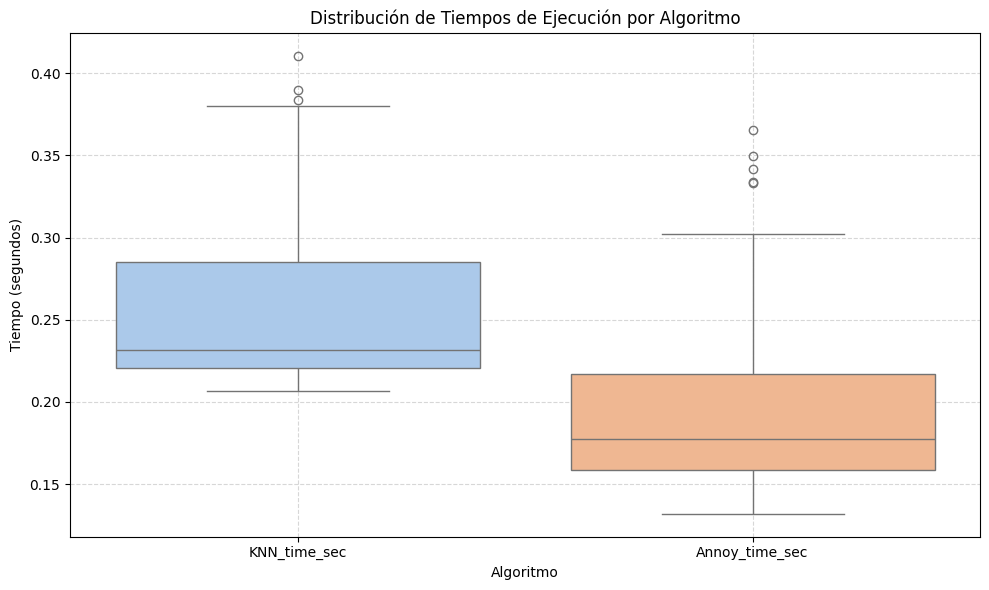

C:\Users\Miguel\AppData\Local\Temp\ipykernel_15388\2037027799.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resumen, x="Algoritmo", y="Tiempo (segundos)", palette="Set2")


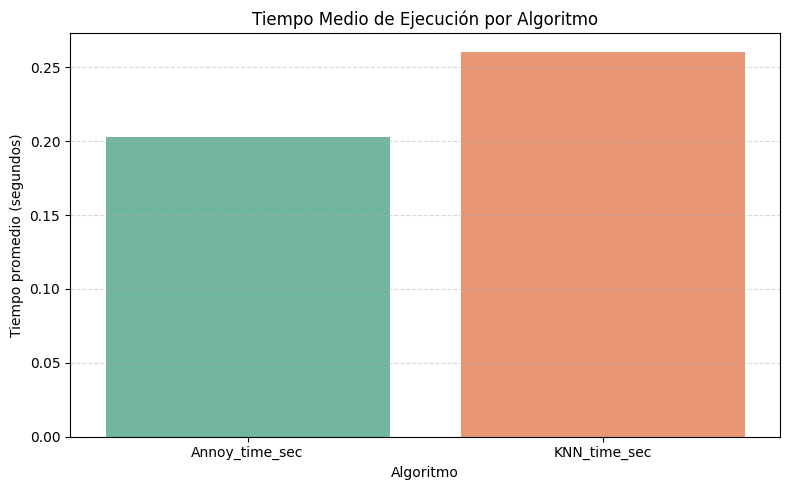

In [26]:
plot_benchmark_comparison(resultados)